In [1]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
from pathlib import Path
# Add project root to Python path
sys.path.insert(0, str(Path.cwd().parent.parent))

from src.dataPipeline import download_light_curves as dl
import lightkurve as lk
from astropy.time import Time

/home/charlie/Documents/github/exoplanet-hunting-ml/.venv/lib64/python3.13/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


In [2]:
kep_meta = pd.read_csv("../../kepler-data/kepler_metadata.csv")
# kep_meta = kep_meta[kep_meta["kepid"].isin([10748390, 11853905, 8191672,  10874614])].reset_index()
# kep_meta.sort_values(by=["kepid"])
# kep_dupes = kep_meta.duplicated(subset=["kepler_name"])
# kep_dupes[kep_dupes == True]
kep_meta


,Unnamed: 0,kepid,kepoi_name,kepler_name,tce_plnt_num,koi_count,koi_comment,koi_period,koi_time0bk,koi_duration,...,tce_period,tce_time0bk,tce_duration,tce_incl,tce_num_transits,tce_model_snr,tce_depth,koi_name,pl_name,ttv_flag
0,0,10797460,K00752.01,Kepler-227 b,1,2,NO_COMMENT,9.488036,170.53875,2.9575,...,9.48803,132.588,3.4190,84.17,142,31.180,630.40,K00752.01,Kepler-227 b,0
1,1,10854555,K00755.01,Kepler-664 b,1,1,NO_COMMENT,2.525592,171.59555,1.6545,...,2.52562,133.703,1.6250,85.60,515,37.310,578.30,K00755.01,Kepler-664 b,0
2,2,10872983,K00756.01,Kepler-228 d,1,3,NO_COMMENT,11.094321,171.20116,4.5945,...,11.09430,137.918,4.6210,87.60,95,59.640,1506.00,K00756.01,Kepler-228 d,0
3,3,10872983,K00756.02,Kepler-228 c,2,3,NO_COMMENT,4.134435,172.97937,3.1402,...,4.13442,131.638,3.4530,77.37,240,37.730,671.50,K00756.02,Kepler-228 c,0
4,4,10872983,K00756.03,Kepler-228 b,3,3,NO_COMMENT,2.566589,179.55437,2.4290,...,2.56658,133.361,2.6470,79.64,355,13.290,206.60,K00756.03,Kepler-228 b,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2343,2343,10843431,K07378.01,Kepler-1999 b,1,2,NO_COMMENT,8.739676,136.58290,3.8660,...,8.73945,136.614,3.7470,81.97,33,12.100,1240.00,K07378.01,Kepler-1999 b,0
2344,2344,7350067,K06863.01,Kepler-1646 b,1,1,CENT_KIC_POS,4.485592,135.43172,0.8161,...,4.48559,135.432,0.8344,89.29,298,39.750,2240.00,K06863.01,Kepler-1646 b,0
2345,2345,8311864,K07016.01,Kepler-452 b,1,1,CENT_FEW_DIFFS,384.847556,314.97000,9.9690,...,384.84600,314.971,10.3900,89.70,4,8.667,175.60,K07016.01,Kepler-452 b,0
2346,2346,7935997,K05447.02,Kepler-1629 b,1,2,SWEET_NTL,3.875943,134.84758,2.3140,...,3.87594,134.850,2.4360,86.65,348,11.200,53.22,K05447.02,Kepler-1629 b,0


In [3]:
lc_folder = "../../kepler-data/light-curves"

all_num_datapoints = []
transit_meta = {}

# TODO iterate over stars, instead of planets. pivot on planet number to get everything on one row per star
for ind, row in kep_meta.iterrows():
    if ind > 15:
        break
    kepler_name = row["kepler_name"]
    kep_id = row["kepid"]
    kic_id = f"KIC{kep_id}"
    planet_number = row["tce_plnt_num"]
    transit_t0 = row["tce_time0bk"]
    transit_duration = row["tce_duration"] 
    transit_period = row["tce_period"]
    num_transits = row["tce_num_transits"]
    transit_snr = row["tce_model_snr"]
    # find out why the tce_ columns don't agree with the koi_ columns. is it just large error bars?
    
    print(f"{kepler_name}, snr = {transit_snr}")
    search_res = lk.search_lightcurve(kic_id, exptime=60)
    if len(search_res) == 0:
        continue
    # print(search_res)
    lc = search_res.download_all().stitch()
    lc = lc.remove_outliers()

    window_padding = 0.2 # days

    # record metadata for all expected transit windows that have data
    viable_transits = []

    for i in range(num_transits):
        transit_i_t0 = transit_t0 + (i * transit_period)

        trans_window_min = transit_i_t0 - (0.5 * transit_duration / 24.0) - window_padding
        trans_window_max = transit_i_t0 + (0.5 * transit_duration / 24.0) + window_padding

        lc_slice = lc.truncate(trans_window_min, trans_window_max, "time")

        num_datapoints = len(lc_slice)
        if num_datapoints == 0:
            continue

        all_num_datapoints.append(num_datapoints)
        # print(num_datapoints)

        viable_transits.append({
            "min": trans_window_min,
            "max": trans_window_max,
            "num_datapoints": num_datapoints
        })

        # lc_slice.scatter(s=5.0, fc="black")
        # plt.show()

        if len(viable_transits) > 50:
            break
    
    if len(viable_transits) > 0:
        transit_meta[kepler_name] = {
            "kep_id": kep_id,
            "planet_number": planet_number,
            "transits": viable_transits
        }

Kepler-227 b, snr = 31.18
Kepler-664 b, snr = 37.31
Kepler-228 d, snr = 59.64
Kepler-228 c, snr = 37.73
Kepler-228 b, snr = 13.29
Kepler-229 c, snr = 133.2
Kepler-1 b, snr = 6930.0
Kepler-2 b, snr = 3565.0
Kepler-8 b, snr = 1687.0
Kepler-466 c, snr = 44.92
Kepler-661 b, snr = 62.79
Kepler-226 c, snr = 54.58
Kepler-226 b, snr = 24.9
Kepler-226 d, snr = 9.95
Kepler-662 b, snr = 27.96
Kepler-663 b, snr = 26.87


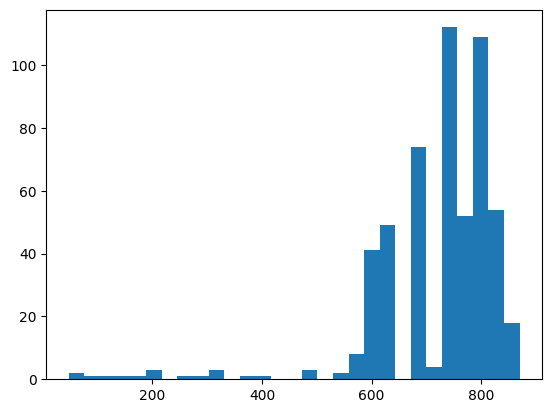

In [4]:
import matplotlib.pyplot as plt

plt.hist(all_num_datapoints, bins='auto')
plt.show()

In [5]:
transit_meta

{'Kepler-664 b': {'kep_id': 10854555,
  'planet_number': 1,
  'transits': [{'min': 631.0162858333333,
    'max': 631.4839941666667,
    'num_datapoints': 687},
   {'min': 633.5419058333333, 'max': 634.0096141666667, 'num_datapoints': 686},
   {'min': 636.0675258333333, 'max': 636.5352341666667, 'num_datapoints': 686},
   {'min': 638.5931458333333, 'max': 639.0608541666667, 'num_datapoints': 687},
   {'min': 641.1187658333333, 'max': 641.5864741666667, 'num_datapoints': 673},
   {'min': 643.6443858333333, 'max': 644.1120941666667, 'num_datapoints': 687},
   {'min': 646.1700058333333, 'max': 646.6377141666667, 'num_datapoints': 687},
   {'min': 648.6956258333333, 'max': 649.1633341666667, 'num_datapoints': 687},
   {'min': 651.2212458333333, 'max': 651.6889541666667, 'num_datapoints': 686},
   {'min': 653.7468658333333, 'max': 654.2145741666667, 'num_datapoints': 686},
   {'min': 656.2724858333333, 'max': 656.7401941666667, 'num_datapoints': 687},
   {'min': 658.7981058333334, 'max': 659

In [3]:
# switch from indexing on planets (kepid + tce_plnt_num) to indexing on stars (kepid)
kep_stars = kep_meta.pivot(
    index="kepid", 
    columns="tce_plnt_num", 
    # values that are per-planet and not per-star
    values=[
        "tce_time0bk",
        "tce_duration",
        "tce_period",
        "tce_num_transits",
        "tce_model_snr"
    ]
)

# get max tce_plnt_num so we know how far to iterate through the pivot columns
max_plnt_num = max(kep_meta["tce_plnt_num"].to_list())
print(f"max tce_plnt_num = {max_plnt_num}")

kep_stars


max tce_plnt_num = 7


tce_time0bk                              tce_duration             \
tce_plnt_num           1        2   3   4   5   6   7            1      2   3   
kepid                                                                           
757450           134.452      NaN NaN NaN NaN NaN NaN        2.074    NaN NaN   
1026957          144.779      NaN NaN NaN NaN NaN NaN        1.333    NaN NaN   
1432789          136.493      NaN NaN NaN NaN NaN NaN        6.048    NaN NaN   
1717722              NaN  132.186 NaN NaN NaN NaN NaN          NaN  1.866 NaN   
1718189          144.322  137.628 NaN NaN NaN NaN NaN        3.601  4.302 NaN   
...                  ...      ...  ..  ..  ..  ..  ..          ...    ...  ..   
12735740         363.072      NaN NaN NaN NaN NaN NaN       10.830    NaN NaN   
12735830         134.598      NaN NaN NaN NaN NaN NaN        2.049    NaN NaN   
12784167         132.203      NaN NaN NaN NaN NaN NaN        1.997    NaN NaN   
12785320         138.383      NaN NaN NaN NaN NaN NaN        2.652    NaN NaN   
12834874         134.747      NaN NaN NaN NaN NaN NaN        3.332    NaN NaN   

              ... tce_num_transits         tce_model_snr                     \
tce_plnt_num  ...                5   6   7             1      2   3   4   5   
kepid         ...                                                             
757450        ...              NaN NaN NaN        431.20    NaN NaN NaN NaN   
1026957       ...              NaN NaN NaN         97.07    NaN NaN NaN NaN   
1432789       ...              NaN NaN NaN         23.99    NaN NaN NaN NaN   
1717722       ...              NaN NaN NaN           NaN  15.23 NaN NaN NaN   
1718189       ...              NaN NaN NaN         21.63  18.40 NaN NaN NaN   
...           ...              ...  ..  ..           ...    ...  ..  ..  ..   
12735740      ...              NaN NaN NaN        443.90    NaN NaN NaN NaN   
12735830      ...              NaN NaN NaN         16.65    NaN NaN NaN NaN   
12784167      ...              NaN NaN NaN         48.51    NaN NaN NaN NaN   
12785320      ...              NaN NaN NaN         31.89    NaN NaN NaN NaN   
12834874      ...              NaN NaN NaN         52.59    NaN NaN NaN NaN   

                      
tce_plnt_num   6   7  
kepid                 
757450       NaN NaN  
1026957      NaN NaN  
1432789      NaN NaN  
1717722      NaN NaN  
1718189      NaN NaN  
...           ..  ..  
12735740     NaN NaN  
12735830     NaN NaN  
12784167     NaN NaN  
12785320     NaN NaN  
12834874     NaN NaN  

[1806 rows x 35 columns]

In [5]:
import numpy as np

lc_folder = "../../kepler-data/light-curves"
window_size = 15000 # 25 hours * 60 exposures per hour
window_size_bjd = 25.0 / 24.0

ind = 0
for kepid, row in kep_stars.iterrows():
    # ind += 1
    # if ind < 4:
    #     continue
    # search and download light curve
    kic_id = f"KIC{kepid}"
    print(f"searching for light curves for {kic_id}...")
    search_res = lk.search_lightcurve(kic_id, exptime=60)
    print("done searching.")
    if len(search_res) == 0:
        continue

    print(f"downloading light curve for {kic_id}...")
    lc = search_res.download_all().stitch()
    print(f"done downloading.")
    # basic pre-processing only, so we know how many usable datapoints we have
    lc = lc.remove_outliers().remove_nans()

    # check if kepid folder exists in destination, if not create it
    kepid_path = os.path.join(lc_folder, str(kepid))
    if not os.path.exists(kepid_path):
        os.mkdir(kepid_path)

        lc_path = os.path.join(kepid_path, "lightcurve.fits")
        if not os.path.exists(lc_path):
            lc.to_fits(lc_path)
    
    # create metadata for viable transit windows and periods of no transits
    transits = []
    # - iterate over range(max_plnt_num) to get tce columns per planet
    for i in range(1, max_plnt_num+1):
        # column names are tuples after the pivot
        transit_t0 = row[("tce_time0bk", i)]
        transit_duration = row[("tce_duration", i)] 
        transit_period = row[("tce_period", i)]
        num_transits = (row[("tce_num_transits", i)])
        transit_snr = row[("tce_model_snr", i)]

        if np.isnan(transit_t0):
            continue

        # - collect metadata for transit windows that have enough datapoints
        for j in range(int(num_transits)):
            transit_j_t0 = transit_t0 + (j * transit_duration)
            trans_window_min = transit_j_t0 + (0.5 * window_size_bjd)
            trans_window_max = transit_j_t0 - (0.5 * window_size_bjd)

            lc_slice = lc.truncate(trans_window_min, trans_window_max, "time")

            num_datapoints = len(lc_slice)
            if num_datapoints == 0:
                continue

            print(num_datapoints)

    # - create windows of no transits, which also have enough datapoints

    # save metadata to json and lightcurve to FITS file
    ind += 1
    if ind > 5:
        break

searching for light curves for KIC757450...
done searching.
downloading light curve for KIC757450...
done downloading.
searching for light curves for KIC1026957...


ReadTimeout: HTTPSConnectionPool(host='mast.stsci.edu', port=443): Read timed out. (read timeout=None)

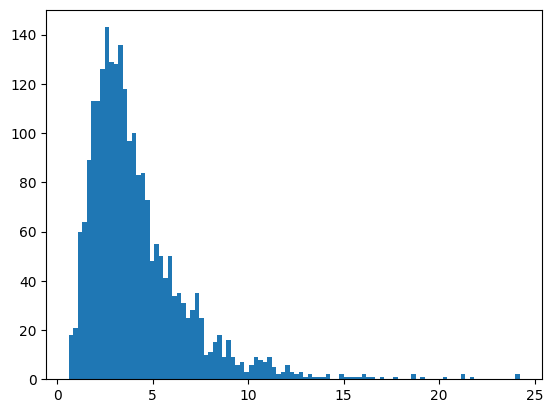

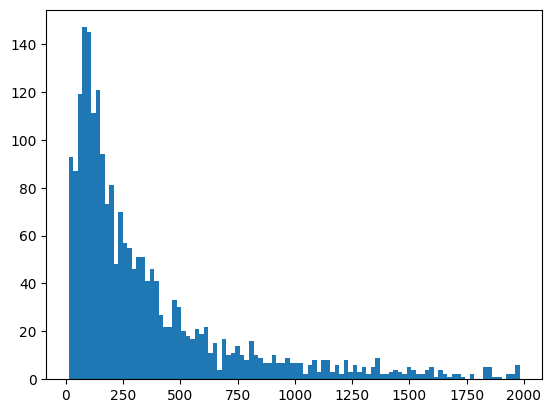

min period = 12.580248000000001
max duration = 24.21


In [11]:
import matplotlib.pyplot as plt

periods = [x *24 for x in kep_meta["tce_period"].to_list() if x*24 < 2000]
durations = kep_meta["tce_duration"].to_list()
plt.hist(durations, label="TCE duration", bins=100)
plt.show()
plt.hist(periods, label="TCE period", bins=100)
# plt.axvline(100.0, color='red', linestyle='--', linewidth=0.5, alpha=0.75)
plt.show()

print(f"min period = {min(periods)}")
print(f"max duration = {max(durations)}")


In [ ]:
row = kep_stars.iloc[0]
row.index

('tce_model_snr', np.int64(7))

In [12]:
25* 60

1500

In [ ]:
# figure out async downloads
import asyncio

lc_folder = "../../kepler-data/light-curves"

async def get_lightcurve_async(kic_id):
    print(f"searching lightcurves for {kic_id}...")
    try:
        search_res = await asyncio.to_thread(
            lk.search_lightcurve, kic_id, exptime=60
        )
    except TimeoutError as err:
        print(f"TimeoutError for {kic_id}")
        return
    print(f"done searching for {kic_id}")

    if len(search_res) == 0:
        print(f"No lightcurves found for {kic_id}")
        return

    print(f"downloading lightcurve for {kic_id}...")
    try:
        lc = await asyncio.to_thread(
            search_res.download_all
        )
    except TimeoutError as err:
        print(f"TimeoutError for {kic_id}")
        return
    print("done downloading.")

    if not lc:
        return

    lc = lc.stitch()
    return lc

async def get_all_lightcurves_async():
    kep_ids = kep_stars.index.to_list()[5:10]

    coroutines = [get_lightcurve_async(f"KIC{id}") for id in kep_ids]

    results = await asyncio.gather(*coroutines)

    print("finished all tasks")
    print(len(results))

In [5]:
await get_all_lightcurves_async()

searching lightcurves for KIC757450...
searching lightcurves for KIC1026957...
searching lightcurves for KIC1432789...
searching lightcurves for KIC1717722...
searching lightcurves for KIC1718189...
done searching for KIC1717722
No lightcurves found for KIC1717722
done searching for KIC757450
downloading lightcurve for KIC757450...


done downloading.
[<KeplerLightCurve length=768494 LABEL="KIC 757450" QUARTER=15 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
       time             flux      ...   pos_corr1      pos_corr2   
                                  ...      pix            pix      
       Time           float32     ...    float32        float32    
------------------ -------------- ... -------------- --------------
 906.8367398677292  1.0129123e+00 ...  2.5607938e-02  8.1560113e-02
 906.8374210910115  1.0132812e+00 ...  2.5601901e-02  8.1575207e-02
 906.8381022145331  1.0161140e+00 ...  2.5595864e-02  8.1590302e-02
 906.8387834380483  1.0199420e+00 ...  2.5589826e-02  8.1605405e-02
 906.8394643613283  1.0151595e+00 ...  2.5583791e-02  8.1620492e-02
 906.8401455848434  1.0204304e+00 ...  2.5577754e-02  8.1635594e-02
 906.8408267083578  1.0229069e+00 ...  2.5571717e-02  8.1650689e-02
 906.8415079316474  1.0117955e+00 ...  2.5565680e-02  8.1665792e-02
 906.8421890551617  1.0199058e+00 ...  2.5559643e-02  8.1680886e